In [1]:
!pip install einops

In [2]:
# import zipfile
# import os

# # Specify the path to the zip file and the extraction directory
# zip_file_path = 'datas.zip'
# extract_to = 'cdata/'

# # Create a directory to extract to, if it doesn't exist
# os.makedirs(extract_to, exist_ok=True)

# # Unzip the file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)

# print("Extraction completed!")


In [1]:
import torch
import torch.nn.functional as F
from torch import Tensor, nn
from torchvision.transforms import Compose, Resize, ToTensor

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

device

device(type='cpu')

### Data Loader

In [3]:
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms

# Set a seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
import os
class_names=[]
base_path = 'classification_dataset_ViT/Tower_crane'
for folder in os.listdir(base_path):
    fol=os.path.join(base_path,folder)
    for fil in os.listdir(fol):
        class_names.append(fil)

class_names


['b41_Collapse',
 'b42_Tipping over',
 'b43_Fall of crane jib, boom, other parts',
 'b44_Fall of load',
 'b45_Collision',
 'b46_Struck-by',
 'b47-Struck by objects',
 'b31_Potential collision',
 'b32_Potential struck-by',
 'b33_ Load tipping or shifting',
 'b11_Assembling,dismantling',
 'b12_Erection',
 'b13_Lifting operation',
 'b14_Safe access to the deck',
 'b21_Inadequate use of PPE',
 'b22_Unstable lifting operation',
 'b23_Unclear division of work area',
 'b24_Unsafe access to a working crane',
 'b25_Operating near power lines']

In [5]:
import os
from sklearn.model_selection import train_test_split

def collect_images(base_path):
    images = []
    label_idx = {}  
    idx = 0  
    for safety_folder in ['Incidents','Near-Miss Incidents','Safe Operations', 'Unsafe Operations']:  # Iterate over safe and unsafe folders
        safety_folder_path = os.path.join(base_path, safety_folder)
        for activity_folder in os.listdir(safety_folder_path):
            activity_folder_path = os.path.join(safety_folder_path, activity_folder)
            if activity_folder not in label_idx: 
                label_idx[activity_folder] = idx
                idx += 1
            i = 0
            for img_file in os.listdir(activity_folder_path):
                if img_file.endswith(('.jpg', '.jpeg', '.png')):  
                    images.append((os.path.join(activity_folder_path, img_file), label_idx[activity_folder]))
                    i += 1


    return images, label_idx

base_path = 'classification_dataset_ViT/Tower_crane'


all_images, label_idx = collect_images(base_path)


train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)

print(f"Training images: {len(train_images)}")
print(f"Testing images: {len(test_images)}")


print("Example of first image:")
print("Path:", train_images[0][0])
print("Label index:", train_images[0][1])


print("\nLabel indices:")
for activity_folder, idx in label_idx.items():
    print(f"{activity_folder}: {idx}")

Training images: 9030
Testing images: 2258
Example of first image:
Path: classification_dataset_ViT/Tower_crane\Incidents\b43_Fall of crane jib, boom, other parts\b43 (312).png
Label index: 2

Label indices:
b41_Collapse: 0
b42_Tipping over: 1
b43_Fall of crane jib, boom, other parts: 2
b44_Fall of load: 3
b45_Collision: 4
b46_Struck-by: 5
b47-Struck by objects: 6
b31_Potential collision: 7
b32_Potential struck-by: 8
b33_ Load tipping or shifting: 9
b11_Assembling,dismantling: 10
b12_Erection: 11
b13_Lifting operation: 12
b14_Safe access to the deck: 13
b21_Inadequate use of PPE: 14
b22_Unstable lifting operation: 15
b23_Unclear division of work area: 16
b24_Unsafe access to a working crane: 17
b25_Operating near power lines: 18


In [6]:
class CustomImageDataset(datasets.VisionDataset):
    def __init__(self, image_label_pairs, transform=None):
        super().__init__(root="", transform=transform)
        self.image_paths = [img[0] for img in image_label_pairs]
        self.labels = [img[1] for img in image_label_pairs]
        self.transform = transform
        self.classes = class_names
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = datasets.folder.default_loader(img_path)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Create datasets
image_datasets = {
    'train': CustomImageDataset(train_images, transform=data_transforms['train']),
    'test': CustomImageDataset(test_images, transform=data_transforms['test'])
}

# Output the dataset sizes
print(f"Training set size: {len(image_datasets['train'])}")
print(f"Test set size: {len(image_datasets['test'])}")

Training set size: 9030
Test set size: 2258


In [7]:
image_datasets

{'train': Dataset CustomImageDataset
     Number of datapoints: 9030
     Root location: 
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset CustomImageDataset
     Number of datapoints: 2258
     Root location: 
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [8]:
batch_size = 8
epochs = 20
lr = 0.0001
gamma = 0.5
seed = 42

In [9]:
train_loader=DataLoader(image_datasets['train'], shuffle=True, batch_size=batch_size, num_workers=0)
valid_loader=DataLoader(image_datasets['test'], shuffle=False, batch_size=batch_size, num_workers=0)

In [10]:
class_names = image_datasets['train'].classes
class_names

['b41_Collapse',
 'b42_Tipping over',
 'b43_Fall of crane jib, boom, other parts',
 'b44_Fall of load',
 'b45_Collision',
 'b46_Struck-by',
 'b47-Struck by objects',
 'b31_Potential collision',
 'b32_Potential struck-by',
 'b33_ Load tipping or shifting',
 'b11_Assembling,dismantling',
 'b12_Erection',
 'b13_Lifting operation',
 'b14_Safe access to the deck',
 'b21_Inadequate use of PPE',
 'b22_Unstable lifting operation',
 'b23_Unclear division of work area',
 'b24_Unsafe access to a working crane',
 'b25_Operating near power lines']

### Model

#### CLS token & Position embedding

In [11]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        ) # this breaks down the image in s1xs2 patches, and then flat them

        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))


    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1) #prepending the cls token
        x += self.positions
        return x

#### Multi Head Attention

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len

        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1/2)

        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)

        return out

In [13]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [14]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, L: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, L * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(L * emb_size, emb_size),
        )

#### Transformer Encoder Block


In [15]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self, emb_size: int = 768, drop_p: float = 0., forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 **kwargs):

        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, L=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [16]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

#### Classification head

In [17]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, len(class_names)))

#### VisionTransformer


In [18]:
class ViT(nn.Sequential):
    def __init__(self,
                in_channels: int = 3,
                patch_size: int = 32,
                emb_size: int = 128,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = len(class_names),
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [21]:
!pip install torchsummary

In [19]:
from torchsummary import summary
print(summary(ViT(), (3,224,224), device='cpu'))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 128, 7, 7]         393,344
         Rearrange-2              [-1, 49, 128]               0
    PatchEmbedding-3              [-1, 50, 128]               0
         LayerNorm-4              [-1, 50, 128]             256
            Linear-5              [-1, 50, 384]          49,536
           Dropout-6            [-1, 8, 50, 50]               0
            Linear-7              [-1, 50, 128]          16,512
MultiHeadAttention-8              [-1, 50, 128]               0
           Dropout-9              [-1, 50, 128]               0
      ResidualAdd-10              [-1, 50, 128]               0
        LayerNorm-11              [-1, 50, 128]             256
           Linear-12              [-1, 50, 512]          66,048
             GELU-13              [-1, 50, 512]               0
          Dropout-14              [-1, 

In [20]:
device

device(type='cpu')

In [21]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [22]:
model = ViT(in_channels = 3,
                patch_size = 16,
                emb_size = 768,
                img_size  = 224,
                depth = 12,
                n_classes =len(class_names)).to(device)

In [23]:
model.to(device)

ViT(
  (0): PatchEmbedding(
    (projection): Sequential(
      (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (1): Rearrange('b e (h) (w) -> b (h w) e')
    )
  )
  (1): TransformerEncoder(
    (0): TransformerEncoderBlock(
      (0): ResidualAdd(
        (fn): Sequential(
          (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (1): MultiHeadAttention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (att_drop): Dropout(p=0, inplace=False)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (2): Dropout(p=0.0, inplace=False)
        )
      )
      (1): ResidualAdd(
        (fn): Sequential(
          (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (1): FeedForwardBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            

In [24]:
import torch
import torch.nn as nn
import torchvision

class CustomHead(nn.Module):
    def __init__(self, in_features, num_classes):
        super(CustomHead, self).__init__()
        # Define a sequence of layers
        self.fc1 = nn.Linear(in_features, 128)  
        self.fc2 = nn.Linear(128, num_classes)  

    def forward(self, x):
        x = self.fc1(x)
        x = nn.ReLU()(x)  
        x = self.fc2(x)
        return x


model = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False


num_features = model.heads[0].in_features
num_classes = len(class_names)  

model.heads[0] = CustomHead(num_features, num_classes)

for param in model.heads[0].parameters():
    param.requires_grad = True

model.to(device)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

### Training and testing

In [25]:
class_weights = torch.tensor([1.0, 1.2, 1.2, 1.0, 1.4, 1.7, 1.7, 1.0], dtype=torch.float32)
class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss()
gamma = 0.001
lr=0.0005
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=gamma)

In [26]:
epochs=10
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    scheduler.step()

  0%|          | 0/1129 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.2534 - acc: 0.9491 - val_loss : 0.0272 - val_acc: 0.9943



  0%|          | 0/1129 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0181 - acc: 0.9968 - val_loss : 0.0242 - val_acc: 0.9951



  0%|          | 0/1129 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0103 - acc: 0.9984 - val_loss : 0.0254 - val_acc: 0.9951



  0%|          | 0/1129 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0090 - acc: 0.9982 - val_loss : 0.0121 - val_acc: 0.9978



  0%|          | 0/1129 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0052 - acc: 0.9988 - val_loss : 0.0091 - val_acc: 0.9973



  0%|          | 0/1129 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.0051 - acc: 0.9987 - val_loss : 0.0264 - val_acc: 0.9938



  0%|          | 0/1129 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.0093 - acc: 0.9978 - val_loss : 0.0471 - val_acc: 0.9881



  0%|          | 0/1129 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.0060 - acc: 0.9982 - val_loss : 0.0121 - val_acc: 0.9969



  0%|          | 0/1129 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.0035 - acc: 0.9982 - val_loss : 0.0147 - val_acc: 0.9956



  0%|          | 0/1129 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.0029 - acc: 0.9987 - val_loss : 0.0124 - val_acc: 0.9956



In [27]:
model_path = 'vit_tower_crane_activity_model_epoch10.pth'


torch.save(model.state_dict(), model_path)


print(f"Model saved to {model_path}")

Model saved to vit_tower_crane_activity_model_epoch10.pth


## Testing the model on test/val dataet

In [28]:
!pip install seaborn

In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize lists to store true labels and predictions
all_val_labels = []
all_val_preds = []

# Evaluate the model on the validation set
with torch.no_grad():
    for data, val_label in valid_loader:
        features = data.to(device)
        val_label = val_label.to(device)

        # Get model predictions
        output = model(features)
        val_preds = output.argmax(dim=1)

        # Collect predictions and true labels
        all_val_labels.extend(val_label.cpu().numpy().tolist())
        all_val_preds.extend(val_preds.cpu().numpy().tolist())


In [30]:
from sklearn.metrics import f1_score

def calculate_score(labels, predictions):
    # Calculate F1 score and accuracy
    f1 = f1_score(labels, predictions, average='weighted')  # Weighted average for multi-class
    accuracy = np.mean(labels == predictions)
    return f1, accuracy
# Calculate F1 score and accuracy for the test dataset
f1, accuracy = calculate_score(np.array(all_val_labels), np.array(all_val_preds))
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy * 100:.2f} %')

F1 Score: 0.9955
Accuracy: 99.56 %


### Classification Report

In [31]:
print(classification_report(all_val_labels, all_val_preds, target_names=[f"Class {i}" for i in range(len(class_names))]))


              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       124
     Class 1       0.98      0.92      0.95        93
     Class 2       1.00      1.00      1.00       191
     Class 3       0.96      0.99      0.97       137
     Class 4       0.99      1.00      0.99        99
     Class 5       1.00      1.00      1.00       110
     Class 6       1.00      1.00      1.00       123
     Class 7       1.00      1.00      1.00        66
     Class 8       1.00      1.00      1.00        91
     Class 9       1.00      1.00      1.00       130
    Class 10       1.00      1.00      1.00       116
    Class 11       0.99      1.00      0.99        80
    Class 12       1.00      0.99      1.00       153
    Class 13       1.00      1.00      1.00       113
    Class 14       1.00      1.00      1.00       132
    Class 15       1.00      1.00      1.00       177
    Class 16       1.00      1.00      1.00        80
    Class 17       1.00    

### Confusion Matrix

In [32]:
cm = confusion_matrix(all_val_labels, all_val_preds)
df_cm = pd.DataFrame(
    cm,
    index = class_names,
    columns = class_names
)
print("confusion matrix done")

confusion matrix done


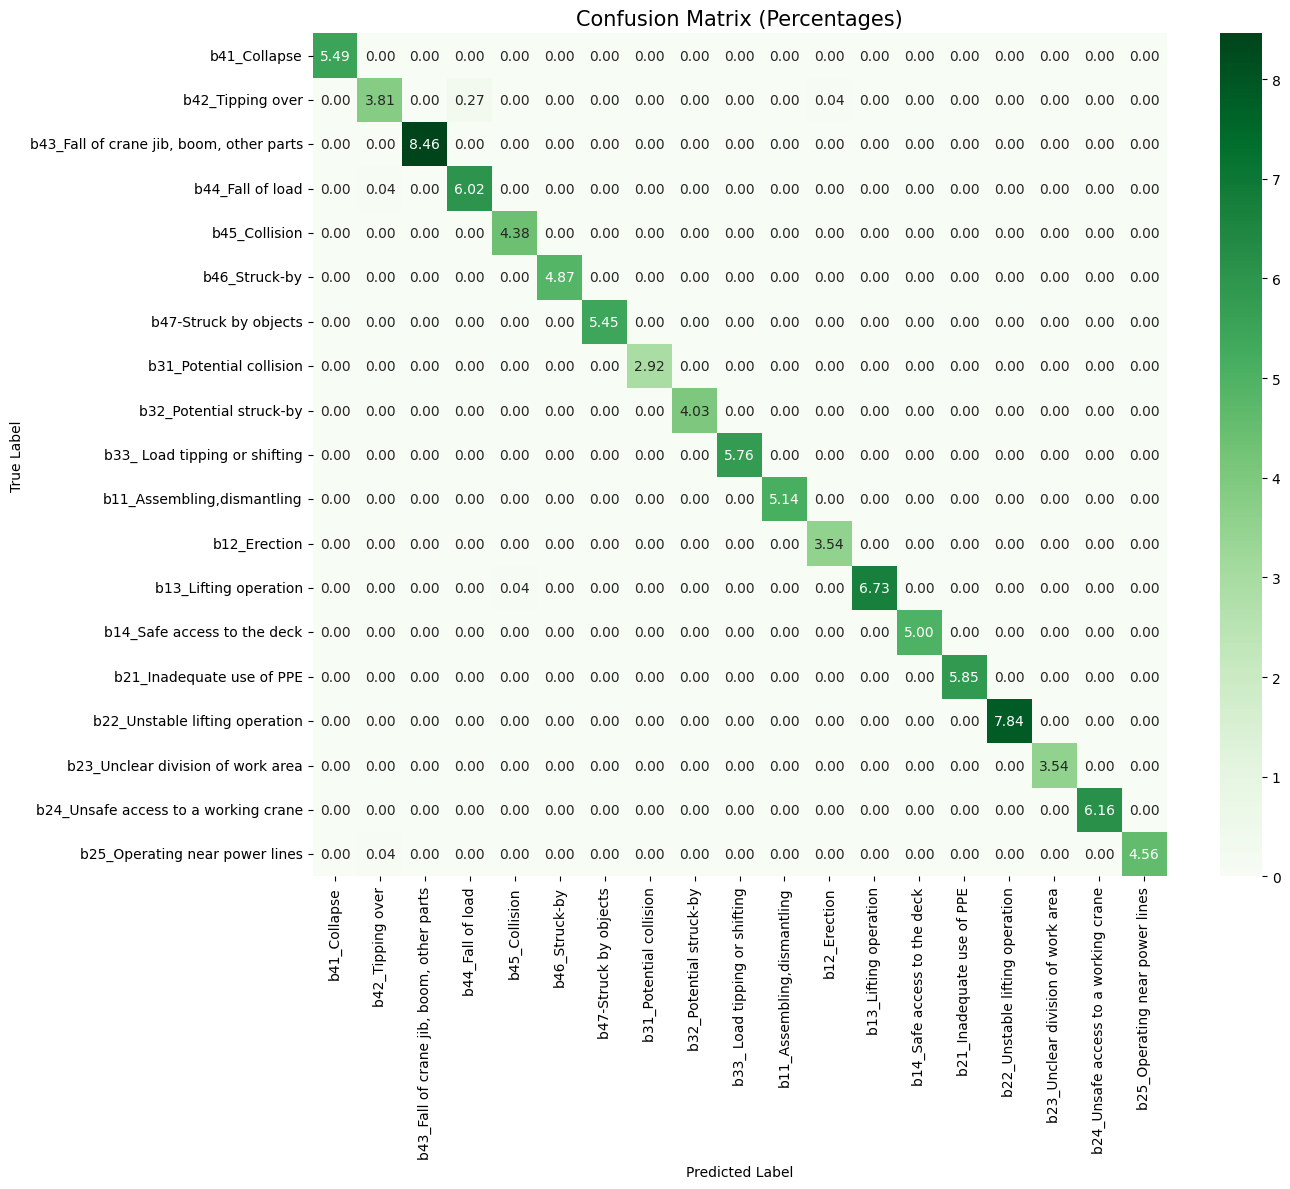

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def show_confusion_matrix(confusion_matrix, save_path="confusion_matrix.png"):
    total = np.sum(confusion_matrix)
    percentages = (confusion_matrix / total) * 100
    

    plt.figure(figsize=(14, 12))
    hmap = sns.heatmap(percentages, annot=True, fmt=".2f", cmap="Greens", 
                      xticklabels=class_names, 
                      yticklabels=class_names)
    
    plt.title("Confusion Matrix (Percentages)", fontsize=15)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    # Adjust layout to prevent clipping
    plt.tight_layout()
    # Save the confusion matrix to a file
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)  # Save as PNG with tight layout

    # Show the plot
    plt.show()


confusion_matrix = np.array(df_cm)

show_confusion_matrix(confusion_matrix, save_path="ViT_Tower_Crane_Confusion_Matrix_percentage.png")



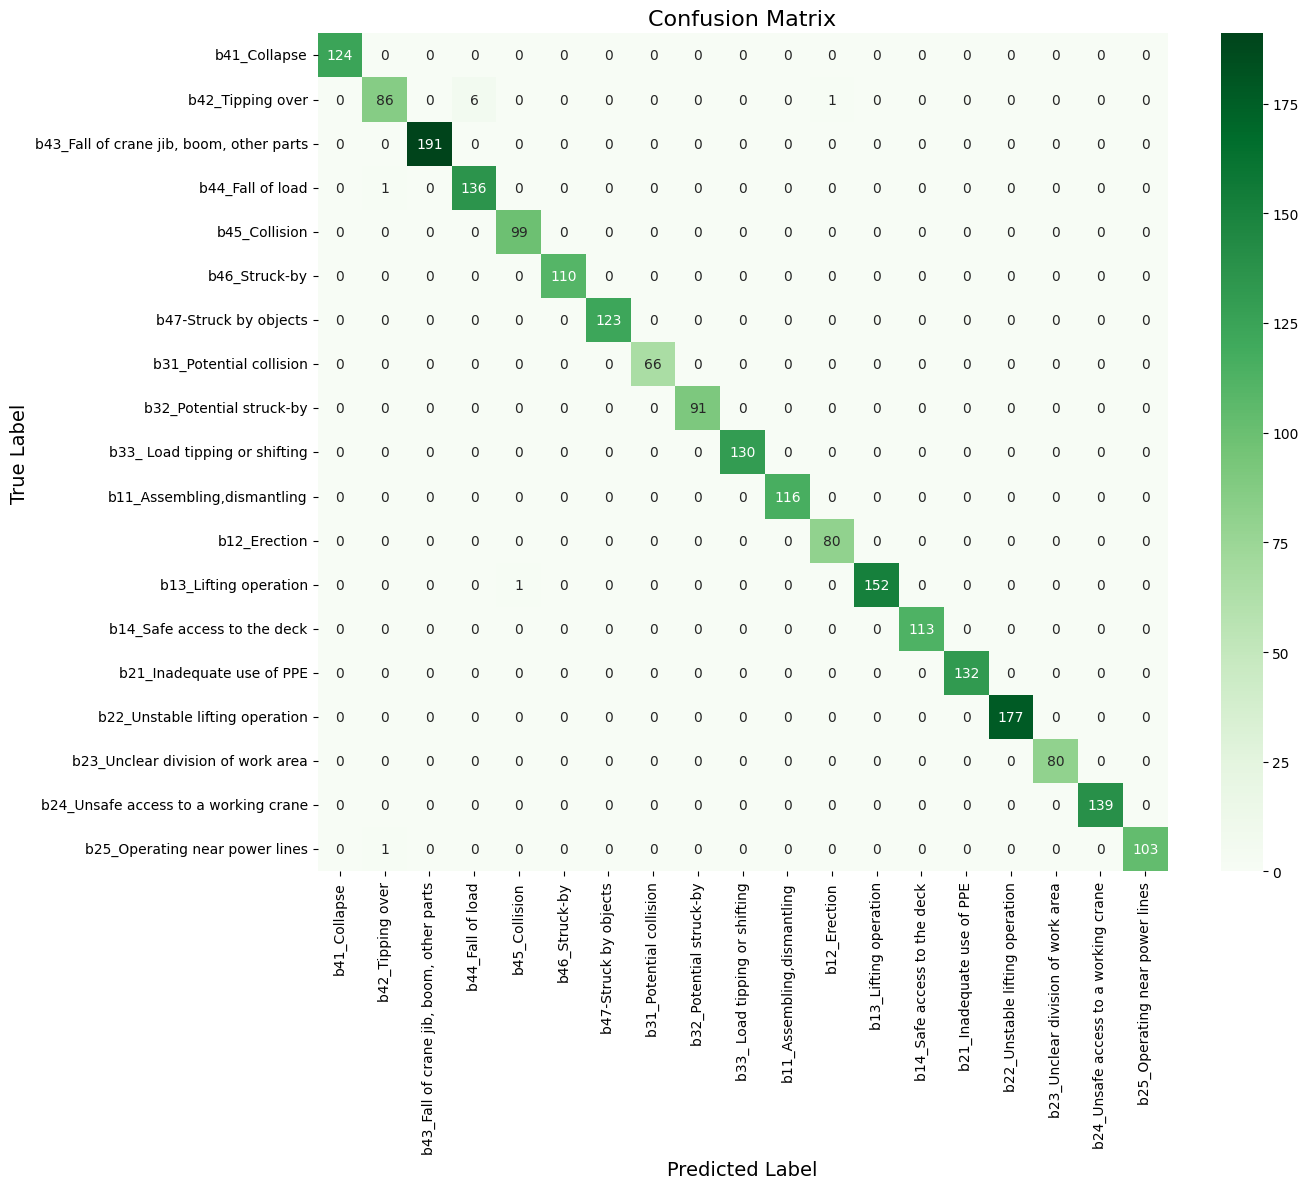

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def show_confusion_matrix(confusion_matrix, save_path="confusion_matrix.png"):
    total = np.sum(confusion_matrix)
    percentages = (confusion_matrix / total) * 100

    annotations = np.empty_like(confusion_matrix, dtype=object)
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            count = confusion_matrix[i, j]
            percent = percentages[i, j]
            annotations[i, j] = f"{count}\n({percent:.1f}%)"

    plt.figure(figsize=(14, 12))
    sns.heatmap(confusion_matrix, annot=True, fmt="", cmap="Greens",
                xticklabels=class_names, 
                yticklabels=class_names)
                # annot_kws={"size": 16, "weight": 'bold'})

    plt.title("Confusion Matrix", fontsize=16)
    plt.ylabel("True Label", fontsize=14)
    plt.xlabel("Predicted Label", fontsize=14)
    # Adjust layout to prevent clipping
    plt.tight_layout()
    # Save the confusion matrix to a file
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)  # Save as PNG with tight layout

    # Show the plot
    plt.show()
    
confusion_matrix = np.array(df_cm)


show_confusion_matrix(confusion_matrix, save_path="ViT_Tower_Crane_Confusion_Matrix_count.png")
